<a href="https://colab.research.google.com/github/jakinng/a-PINN/blob/main/turbulence_DNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 31.6 MB/s eta 0:00:00


In [2]:
# Dependencies for generating turbulence

import math
# import numpy as np
import jax.numpy as jnp
import jax
import pandas as pd
import netCDF4 as nc
import matplotlib.pyplot as plt
import os
from jax import jit

#.   # @jit


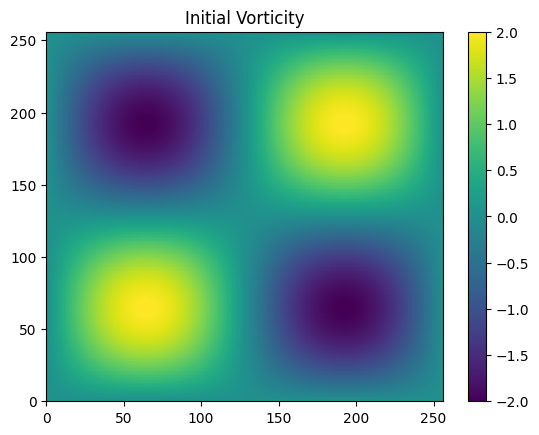

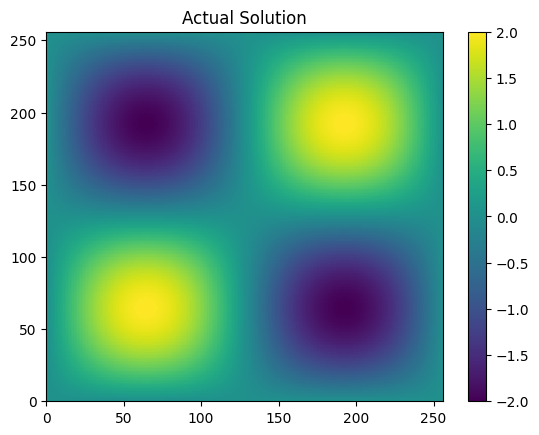

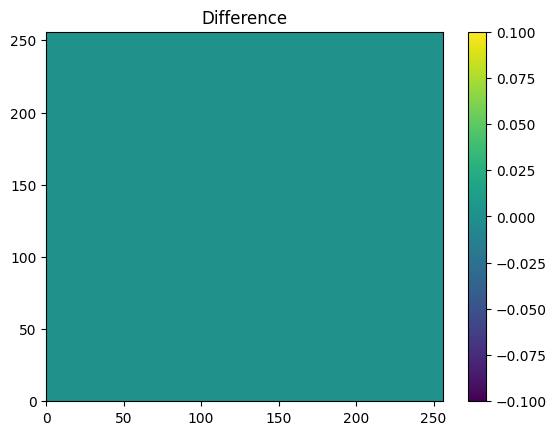

0.0
filename='/content/drive/MyDrive/Stanford/2024_02_01/fake_turbulence_omegahat0_256_100_.nc'
step = 0    time = 0   dt = 5.224574124440551e-05


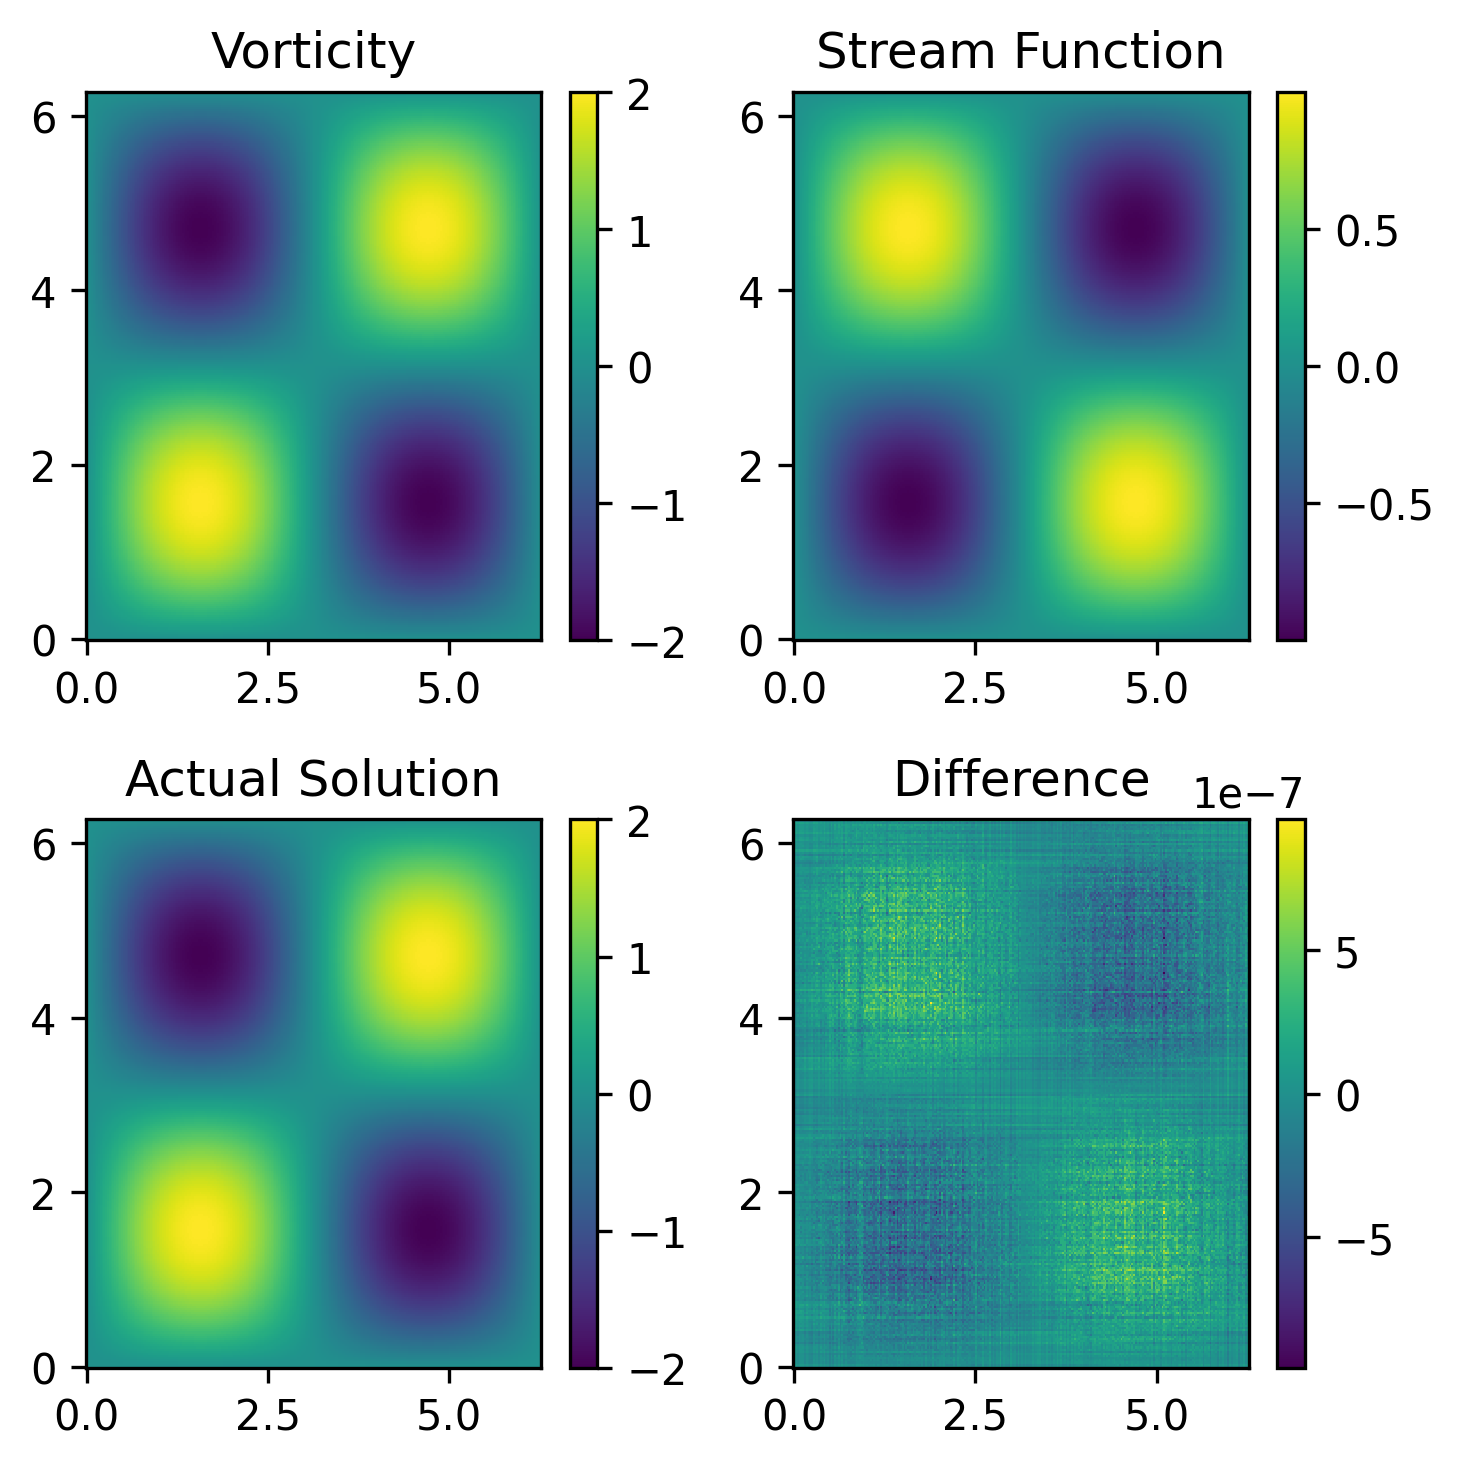

In [ ]:
# @title Turbulence Code
# From https://twitter.com/CFDonia/status/1659560884769832961/photo/1
# https://marinlauber.github.io/2D-Turbulence/

def run_turbulence():
    L = 2 * jnp.pi  # length of x and y scales in square domain with LxL = [0, 2pi]x[0, 2pi]
    kappa = 1 # Number of vortices in each direction for Taylor-Green initial condition
    nu = 1 / Re
    # nu = 5e-4 # 5e-4  # kinematic viscosity -- Reynolds number = lv/nu where l is characteristic length, v is characteristic velocity, and nu is kinematic viscosity
    # Re = 1 / nu
    # Sc = 0.7  # Schmidt number
    # beta = 0  # meridional gradient of Coriolis parameter
    # ar = 0 # 0.02  # random number amplitude for velocity field initialization
    # b = 1  # mean scalar gradient
    CFLmax = jnp.sqrt(3)
    seed = 1324
    key = jax.random.PRNGKey(seed)

    # Create domain and spectral domain -- kx, ky are the wavenumbers in (discrete) Fourier domain
    x = jnp.linspace(0, L, N, endpoint=False)
    y = jnp.linspace(0, L, N, endpoint=False)
    dx = L / N
    dy = L / N
    X, Y = jnp.meshgrid(x, y)
    kx = jnp.fft.fftfreq(N, d = L / (N * 2 * jnp.pi)) # DFT sample frequencies
    ky = jnp.fft.fftfreq(N, d = L / (N * 2 * jnp.pi))
    KX, KY = jnp.meshgrid(kx, ky)

    # 2/3 dealiasing rule, since there are at most second-order derivatives https://math.jhu.edu/~feilu/notes/DealiasingFFT.pdf https://arxiv.org/pdf/1606.05432.pdf https://github.com/ketch/PseudoSpectralPython/blob/master/PSPython_03-FFT-aliasing-filtering.ipynb
    # Create expanded discrete Fourier series, apply multiplication/convolution, then transform back and discard higher frequencies
    M = 3 * (N // 2)
    # kx_M = jnp.fft.fftfreq(M, d = L / (M * 2 * jnp.pi))
    # ky_M = jnp.fft.fftfreq(M, d = L / (M * 2 * jnp.pi))
    # KXM, KYM = jnp.meshgrid(kx_M, ky_M)
    # filter = jnp.ones((M, M))
    index_kmax = math.ceil(M / 3)
    idx_l = index_kmax
    idx_u = 2 * index_kmax
    # filter = filter.at[idx_l:idx_u, idx_l:idx_u].set(0)

    def padded(array):
        padded = jnp.concatenate((array[:N//2], jnp.zeros(shape = (N // 2, N)), array[N // 2:]), axis = 0)
        padded = jnp.concatenate((padded[:, :N//2], jnp.zeros(shape = (3 * (N // 2), N // 2)), padded[:, N // 2:]), axis = 1)
        return padded

    def unpadded(array):
        unpadded = jnp.concatenate((array[:idx_l], array[idx_u:]), axis = 0)
        unpadded = jnp.concatenate((unpadded[:, :idx_l], unpadded[:, idx_u:]), axis = 1)
        return unpadded

    # Sampled x- and y-derivatives in frequency domain (Algorithm 1 in https://math.mit.edu/~stevenj/fft-deriv.pdf)
    ddx = KX * 1j # d/dx of basis function b_kx,ky = e^(i(kx * x / + ky * y)) is i * kx * b_kx,ky https://marinlauber.github.io/2D-Turbulence/
    ddy = KY * 1j # To compute ddx(v), elementwise multiply ddx * v
    # Spectral inverse of del^2 (Laplacian) in frequency domain, where del2 = d^2f/dx^2 + d^2f/dy^2
    # Note that psi_hat = omega_hat / (kx^2 + ky^2) = -idel2 * omegahat (relationship between vorticity and streamfunction)
    # Here idel2 = 1 / ((1j * KX) ** 2 + (1j * KY) ** 2) = -1 / k2
    k2 = KX ** 2 + KY ** 2
    idel2 = -1 / k2
    idel2 = idel2.at[0, 0].set(0) # The mode is the mean value of psi, and results in a division by zero. To avoid rounding error, explicitly set this to zero every computation.

    # initial_cond = "taylor-green"
    # if initial_cond == "taylor-green":
        # Taylor-Green vortex, known solution to N-S equations: https://en.wikipedia.org/wiki/Taylor%E2%80%93Green_vortex
        # Used for testing/validation of temporal accuracy of N-S equations
        # u = jnp.sin(kappa * X) * jnp.cos(kappa * Y) #+ ar * jax.random.uniform(key = key, shape = (N, N)) # x-component of velocity
        # v = -1 * jnp.cos(kappa * X) * jnp.sin(kappa * Y) #+ ar * jax.random.uniform(key = key, shape = (N, N)) # y-component of velocity

        # # Plot difference between result with padded arrays (dealiased) and non-padded arrays
        # u_hat = jnp.fft.fft2(u)
        # v_hat = jnp.fft.fft2(v)
        # h = plt.pcolormesh(jnp.fft.fft2(jnp.fft.ifft2(u_hat).real * jnp.fft.ifft2(v_hat).real).real)
        # plt.title(f"Velocity u * v fourier")
        # plt.colorbar(h)
        # plt.show()

        # padded_ifft2 = jnp.fft.fft2(jnp.fft.ifft2(padded(u_hat)).real * jnp.fft.ifft2(padded(v_hat)).real).real
        # padded_ifft2 = unpadded(padded_ifft2)
        # h = plt.pcolormesh(padded_ifft2)
        # plt.title(f"Velocity u * v fourier padded")
        # plt.colorbar(h)
        # plt.show()

        # # 2D Fourier Transform
        # uhat = jnp.fft.fft2(u)
        # vhat = jnp.fft.fft2(v)
        # omegahat = ddx * vhat - ddy * uhat  # vorticity: omega = curl((u, v)) in 2D
        # omega = jnp.fft.ifft2(omegahat).real # * filter).real
        # psihat = idel2 * omegahat # spectral stream function from spectral vorticity
        # psi = jnp.fft.ifft2(psihat).real

    def solution(t):
        return 2 * jnp.sin(kappa * X) * jnp.sin(kappa * Y)* jnp.exp(-2 * kappa**2 * nu * t)

    omega = solution(0)
    omegahat = jnp.fft.fft2(omega)
    psihat = idel2 * omegahat
    psi = jnp.fft.ifft2(psihat).real
    u_hat = ddy * psihat # hat(dpsi/dy)
    v_hat = -1 * ddx * psihat # -hat(dpsi/dx)
    u = jnp.fft.ifft2(u_hat).real
    v = jnp.fft.ifft2(v_hat).real

    h = plt.pcolormesh(omega)
    plt.colorbar(h)
    plt.title("Initial Vorticity")
    if plot:
        plt.show()
    plt.close()

    time = 0
    def solution(t):
        return 2 * jnp.sin(kappa * X) * jnp.sin(kappa * Y)* jnp.exp(-2 * kappa**2 * nu * t)
    h = plt.pcolormesh(solution(time))
    plt.colorbar(h)
    plt.title("Actual Solution")
    if plot:
        plt.show()
    plt.close()

    h = plt.pcolormesh(omega - solution(time))
    plt.colorbar(h)
    plt.title("Difference")
    if plot:
        plt.show()
    plt.close()
    print(jnp.max(omega - solution(time)))

    print(f"{filename=}")
    if os.path.isfile(filename):
        os.remove(filename)  ## COMMENT OUT THIS LINE TO NOT DESTROY FILE
    ds = nc.Dataset(filename, "w", format="NETCDF4")
    ds.description = description
    # ds.variation = f"Filter out frequencies outside of {kx[idx_u - 1]} and {kx[idx_l]}."
    ds.source = "Adapted code from https://twitter.com/CFDonia/status/1659560884769832961/photo/1 into Python by Jakin Ng."

    x_dim = ds.createDimension("x", N)
    y_dim = ds.createDimension("y", N)
    time_dim = ds.createDimension("time", None)

    ds.createVariable("x", "f4", ("x"))
    ds.createVariable("y", "f4", ("y"))
    ds.createVariable("time", "f4", ("time"))
    ds.createVariable("u", "f4", ("x", "y", "time"))
    ds.createVariable("v", "f4", ("x", "y", "time"))
    ds.createVariable("vorticity", "f4", ("x", "y", "time"))
    ds.createVariable("psi", "f4", ("x", "y", "time"))

    ds["x"][:] = x
    ds["y"][:] = y
    ds["time"][0] = 0
    ds["u"][:, :, 0] = u
    ds["v"][:, :, 0] = v
    ds["vorticity"][:, :, 0] = omega
    ds["psi"][:, :, 0] = psi

    ### Third-order Runge-Kutta
    # dt = 0.5 * min(dx, dy)
    # Determine dt
    Dc =  jnp.max(jnp.pi * ((1 + jnp.abs(u)) / dx + (1 + jnp.abs(v)) / dy)) # convective velocity scale
    Dmu = jnp.max(jnp.pi**2 * (dx ** (-2) + dy ** (-2)))
    dt = CFLmax / (Dc + Dmu) # adaptive timestep based on CFL number

    nstep = 0
    time = 0
    while time < tend:
        # Update using time integration
        omegahat0 = omegahat
        s = 3 # s-order RK method
        if scheme == "RK3":
            for l in range(s, 0, -1):
                psihat = idel2 * omegahat # spectral stream function from spectral vorticity

                # Add convective/advective term
                u_hat = ddy * psihat # hat(dpsi/dy)
                v_hat = -1 * ddx * psihat # -hat(dpsi/dx)
                u = jnp.fft.ifft2(u_hat).real
                v = jnp.fft.ifft2(v_hat).real
                domega_dx_hat = ddx * omegahat
                domega_dy_hat = ddy * omegahat

                # Pad before ifft2 to avoid aliasing
                padded_u = jnp.fft.ifft2(padded(u_hat)).real
                padded_v = jnp.fft.ifft2(padded(v_hat)).real
                padded_domega_dx = jnp.fft.ifft2(padded(domega_dx_hat)).real
                padded_domega_dy = jnp.fft.ifft2(padded(domega_dy_hat)).real
                convection = padded_u * padded_domega_dx + padded_v * padded_domega_dy
                convection_hat = unpadded(jnp.fft.fft2(convection)) # unpad the resulting spectrum

                # Diffusion/viscous term of the Navier-Stokes: domega_hat/dt = (convection) + 1/Re * (-k_x^2 -k_y^2) * omega_hat
                diffusion_hat = -1 * k2 * omegahat / Re

                # Try +/-1 * convection_hat and +/- * diffusion_hat
                omegahat = omegahat0 + (dt / l) * (-1 * convection_hat + diffusion_hat)

        # Update CFL number based on worst cell of domain, and use adaptive timestep based on cfl number
        # https://marinlauber.github.io/2D-Turbulence/#Spectral
        # CFL = jnp.max(jnp.abs(u)) / dx * dt + jnp.max(jnp.abs(v)) / dy * dt
        # dt = CFLmax / CFL * dt

        Dc =  jnp.max(jnp.pi * ((1 + jnp.abs(u)) / dx + (1 + jnp.abs(v)) / dy)) # convective velocity scale
        Dmu = jnp.max(jnp.pi ** 2 * (dx ** (-2) + dy ** (-2)))
        dt = CFLmax / (Dc + Dmu) # adaptive timestep based on CFL number

        # if nstep % 1000 == 0:
        # Print and plot
        if math.floor(time // 3) != math.floor((time - dt) // 3):
            psi = jnp.fft.ifft2(psihat).real
            omega = jnp.fft.ifft2(omegahat).real
            print(
                f"step = {nstep}    time = {time}   dt = {dt}"
            )
            if plot:
                fig = plt.figure(figsize=[5, 5], dpi=300)

                ax = plt.subplot(221)
                ax.set_title("Vorticity")
                pcolor = ax.pcolormesh(x, y, omega, shading="auto")
                plt.colorbar(pcolor, ax=ax)

                ax = plt.subplot(222)
                ax.set_title("Stream Function")
                pcolor = ax.pcolormesh(x, y, psi, shading="auto")
                plt.colorbar(pcolor, ax=ax)

                ax = plt.subplot(224)
                ax.set_title("Difference")
                pcolor = ax.pcolormesh(x, y, omega - solution(time), shading="auto")
                plt.colorbar(pcolor, ax=ax)

                ax = plt.subplot(223)
                ax.set_title("Solution Vorticity")
                def _compute_spectrum(psihat, res = 200):
                    # angle averaged TKE spectrum
                    tke = jnp.real(.5 * k2 * psihat * jnp.conj(psihat))
                    kmod = jnp.sqrt(k2)
                    k = jnp.arange(1, N // 2 + 1, 1, dtype=jnp.float64) # nyquist limit for this grid
                    E = jnp.zeros_like(k)
                    dk = (jnp.max(k) - jnp.min(k)) / res

                    #  binning energies with wavenumber modulus in threshold
                    for i in range(len(k)):
                        E = E.at[i].add(jnp.sum(tke[(kmod < k[i] + dk) & (kmod >= k[i] - dk)]))
                    sum_E = jnp.sum(E)
                    return k, E / sum_E

                def plot_spec(ax, res=200):
                    k, E = _compute_spectrum(200)
                    ax.loglog(k, E, '-k', label="E(k)")
                    ax.set_xlabel("k")
                    ax.set_ylabel("E(k)")

                # plot_spec(ax)

                h = ax.pcolormesh(x, y, solution(time), shading="auto")
                plt.colorbar(h, ax=ax)

                plt.tight_layout()
                plt.savefig(f"{filename[:-3]}{nstep}.png")
                plt.show()

        # Save
        if nstep % 100 == 0:
            t_idx = len(ds["time"][:])
            ds["time"][t_idx] = time
            ds["u"][:, :, t_idx] = u
            ds["v"][:, :, t_idx] = v
            ds["vorticity"][:, :, t_idx] = omega
            ds["psi"][:, :, t_idx] = psi
            ds.close()
            ds = nc.Dataset(filename, "r+", format="NETCDF4")

        ## Increment
        time = time + dt
        nstep = nstep + 1

    ds.close()

# run_turbulence(include_phi = True, forcing = False, symmetric_index = True, filename = "/content/drive/MyDrive/6_27/test_no_forcing.nc")
N = 256
Re = 100
description = f"omegahat0_{N}_{Re}_"
cluster = False
if cluster:
    filename = f"{description}.nc"
else:
    filename = f"/content/drive/MyDrive/Stanford/2024_02_01/fake_turbulence_{description}.nc"

tend = 50
# forcing=True
description="Generated turbulence data using third-order Runge-Kutta method."
plot=True
Re=8000
scheme="RK3"

# jax.config.update("jax_enable_x64", True)
run_turbulence()

In [ ]:
#@title Create .mp4 from .nc turbulence file

import netCDF4 as nc
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import numpy as np
import argparse

parser = argparse.ArgumentParser()
parser.add_argument("-f", "--Filename", help = "Filename to read turbulence data from, such as turbulence.nc")
args = parser.parse_args()
if args.Filename:
    filename = args.Filename
else:
    filename = "dns-turbulence_128_2000_.nc"

L = 2 * math.pi  # length of x and y scales in square domain with LxL = [0, 2pi]x[0, 2pi]
# Create domain and spectral domain -- kx, ky are the wavenumbers in (discrete) Fourier domain
x = np.linspace(0, L, N, endpoint=False)
y = np.linspace(0, L, N, endpoint=False)

ds = nc.Dataset(filename, "r+", format="NETCDF4")
t_max = ds['time'].shape[0]
print(f"{t_max=}")
description = filename[:-3]#"dns-turbulence_128_2000_"
vmax = ds['vorticity'][:,:,:].max()
vmin = ds['vorticity'][:,:,:].min()
print(vmax)
print(vmin)
for t in range(t_max):
    if t % 50 == 0:
        plt.axis('equal')
        plt.pcolormesh(x, y, ds['vorticity'][:,:,t], vmax = vmax, vmin = vmin)
        plt.savefig(f"{description}_{t:05}.png")
        plt.show(block=False)
        plt.pause(0.1)

In [ ]:
!pip install ffmpeg

In [ ]:
!ffmpeg -framerate 30 -pattern_type glob -i "/content/drive/MyDrive/Stanford/2024_02_01/fake_turbulence_128_*.png" \-c:v libx264 -pix_fmt yuv420p "/content/drive/MyDrive/Stanford/2024_02_01/fake_turbulence_128_.mp4"

In [ ]:
## MCWILLIAMS INITIAL CONDITION
    elif initial_cond == "mcwilliams":
        """
        Generates McWilliams vorticity field, see:
            McWilliams (1984), "The emergence of isolated coherent vortices in turbulent flow"
        """
        def generate_vorticity_mcwilliams():
            nk = N//2+1

            # generate variable
            k2 = kx[:nk]**2 + ky[:,jnp.newaxis]**2
            fk = (k2 != 0.0)

            # ensemble variance proportional to the prescribed scalar wavenumber function
            ck = jnp.zeros((N, nk))
            ck = ck.at[fk].set((jnp.sqrt(k2[fk])*(1+(k2[fk]/36)**2))**(-1))

            # Gaussian random realization for each of the Fourier components of psi
            psih = jax.random.normal(key = key, shape = (N, nk))*ck+1j*jax.random.normal(key = key, shape = (N, nk))*ck

            # ṃake sure the stream function has zero mean
            cphi = 0.65*jnp.max(kx)
            wvx = jnp.sqrt(k2)
            filtr = jnp.exp(-23.6*(wvx-cphi)**4.)
            filtr = filtr.at[wvx<=cphi].set(1.)
            def _spec_variance(ph):
                # only half the spectrum for real ffts, needs spectral normalisation
                nx, nk = ph.shape
                ny = (nk-1)*2
                var_dens = 2 * jnp.abs(ph)**2 / (nx*ny)**2
                # only half of coefs [0] and [nx/2+1] due to symmetry in real fft2
                var_dens = var_dens.at[..., 0].divide(2.)
                var_dens = var_dens.at[...,-1].divide(2.)

                return var_dens.sum(axis=(-2,-1))
            KEaux = _spec_variance(filtr*jnp.sqrt(k2)*psih)
            psi = psih/jnp.sqrt(KEaux)

            # inverse Laplacian in k-space
            wh = k2 * psi

            # vorticity in physical space
            field = jnp.fft.irfft2(wh)
            return field
        omega = generate_vorticity_mcwilliams()
        omegahat = jnp.fft.fft2(omega)
        psihat = idel2 * omegahat
        psi = jnp.fft.ifft2(psihat).real
        u_hat = ddy * psihat # hat(dpsi/dy)
        v_hat = -1 * ddx * psihat # -hat(dpsi/dx)
        u = jnp.fft.ifft2(u_hat).real
        v = jnp.fft.ifft2(v_hat).real

In [ ]:
ffmpeg -framerate 30 -pattern_type glob -i "mcwilliams-omega-_128_2000_ar0*.png" \-c:v libx264 -pix_fmt yuv420p "mcwilliams-omega-_128_2000_ar0.mp4"